In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

In [148]:
# Using seaborn's style
plt.style.use('seaborn')

In [149]:
def plot_series(data, title=None, xlabel=None, ylabel=None, figsize=(10, 5), labels=None):
    fig, ax = plt.subplots(figsize=figsize)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if title:
        ax.set_ylabel(ylabel)
    
    lines = ax.plot(data)
    if labels:
        ax.legend(lines, labels)
    
    return fig, ax

def plot_2_cols_series(data1, data2, title1=None, xlabel1=None, ylabel1=None, title2=None, xlabel2=None, ylabel2=None, figsize=(10, 5)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    if title1:
        axs[0].set_title(title1)
    if xlabel1:
        axs[0].set_xlabel(xlabel1)
    if title1:
        axs[0].set_ylabel(ylabel1)
    axs[0].plot(data1)

    if title2:
        axs[1].set_title(title2)
    if xlabel2:
        axs[1].set_xlabel(xlabel2)
    if title2:
        axs[1].set_ylabel(ylabel2)
    axs[1].plot(data2)

    return fig, axs

def plot_3_cols_series(data1, data2, data3, title1=None, xlabel1=None, ylabel1=None, title2=None, xlabel2=None, ylabel2=None, title3=None, xlabel3=None, ylabel3=None, figsize=(16, 5)):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    if title1:
        axs[0].set_title(title1)
    if xlabel1:
        axs[0].set_xlabel(xlabel1)
    if title1:
        axs[0].set_ylabel(ylabel1)
    axs[0].plot(data1)

    if title2:
        axs[1].set_title(title2)
    if xlabel2:
        axs[1].set_xlabel(xlabel2)
    if title2:
        axs[1].set_ylabel(ylabel2)
    axs[1].plot(data2)

    if title3:
        axs[2].set_title(title3)
    if xlabel3:
        axs[2].set_xlabel(xlabel3)
    if title3:
        axs[2].set_ylabel(ylabel3)
    axs[2].plot(data3)

    return fig, axs

def save_fig(name, fig):
    fig.savefig(f"/Users/francescore/Desktop/Project NAML/plots/{name}.pdf", format='pdf', bbox_inches='tight')

In [150]:
# import dataset as a time series
df = pd.read_csv('dataset/bitcoin_price_train.csv', index_col='Date', parse_dates=True)

# keep only the closing price and rename it to 'price'
df = df[['Close']].rename(columns={'Close': 'price'})

In [151]:
df.head()

,price
Date,
2017-07-31,2875.34
2017-07-30,2757.18
2017-07-29,2726.45
2017-07-28,2809.01
2017-07-27,2671.78


In [152]:
df.describe()

,price
count,1556.000000
mean,584.239396
std,525.904442
min,68.430000
25%,254.320000
50%,438.855000
75%,663.402500
max,2958.110000


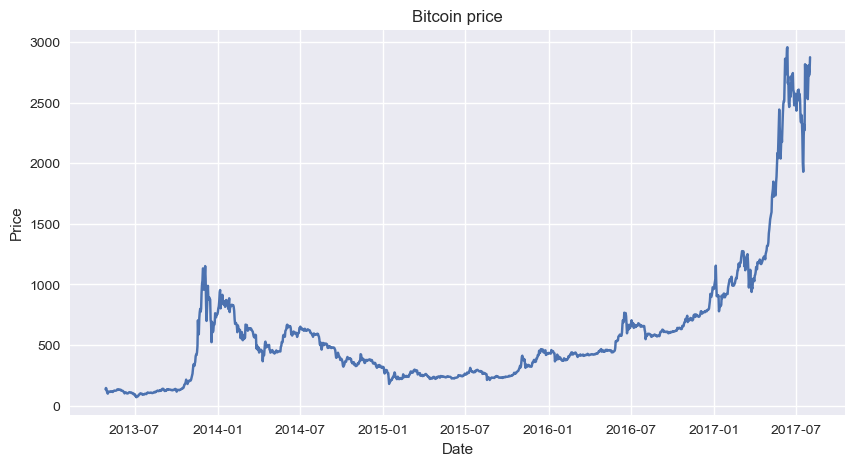

In [153]:
# plot bitcoin price
fig, _ = plot_series(df['price'], title='Bitcoin price', xlabel='Date', ylabel='Price')
save_fig('00_bitcoin_price', fig)

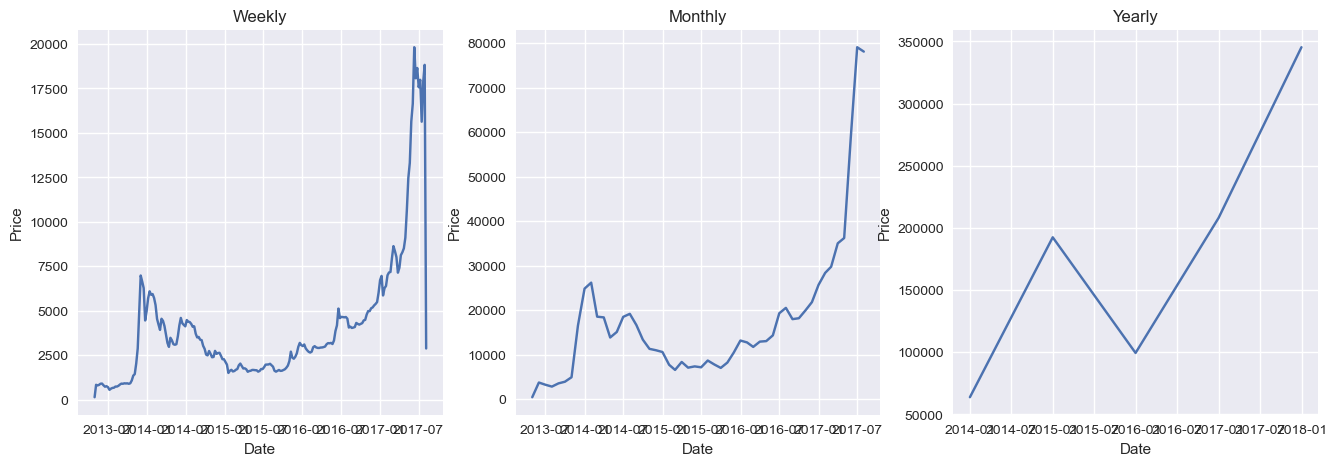

In [154]:
# resample data to weekly basis
df_weekly = df.resample('W').sum()

# resample data to monthly basis
df_monthly = df.resample('M').sum()

# resample data to yearly basis
df_yearly = df.resample('Y').sum()


fig, _ = plot_3_cols_series(df_weekly['price'], df_monthly['price'], df_yearly['price'], title1='Weekly', title2='Monthly', title3='Yearly', xlabel1='Date', xlabel2='Date', xlabel3='Date', ylabel1='Price', ylabel2='Price', ylabel3='Price')
save_fig('03_resamples_compact', fig)

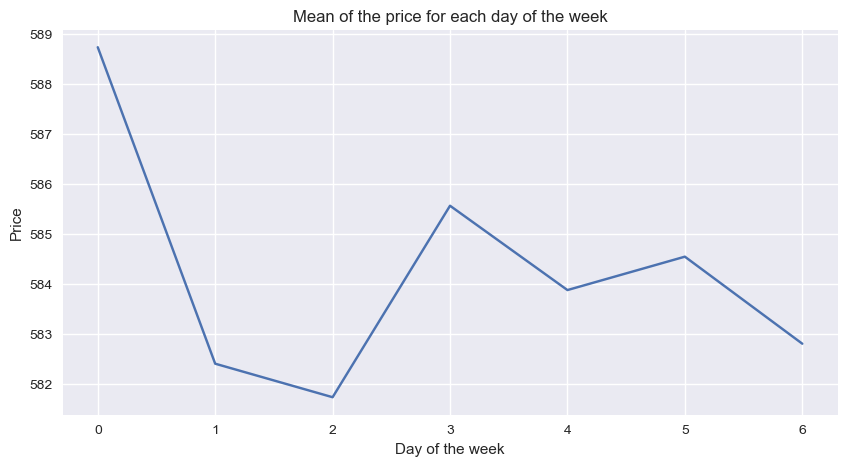

In [155]:
# mean of the price for each day of the week
result = df.groupby(df.index.dayofweek).mean()['price']
fig, _ = plot_series(result, title='Mean of the price for each day of the week', xlabel='Day of the week', ylabel='Price')
save_fig('04_mean_of_the_price_for_each_day_of_the_week', fig)

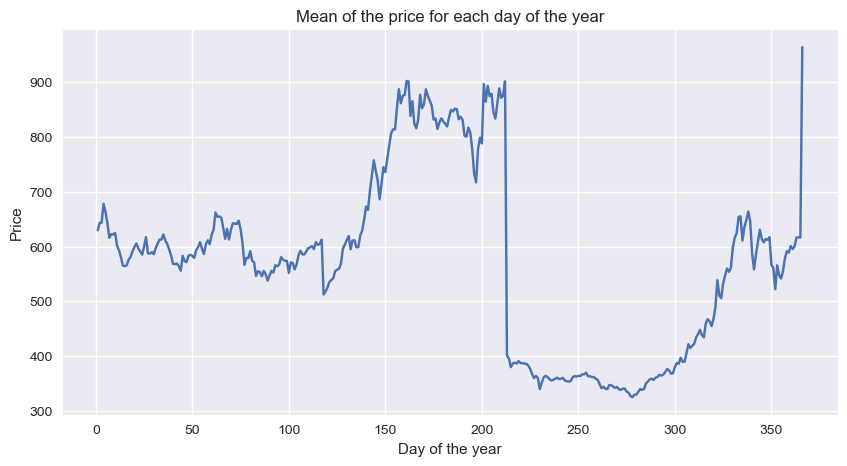

In [156]:
# mean of the price for each day of the year
result = df.groupby(df.index.dayofyear).mean()['price']
fig, _ = plot_series(result, title='Mean of the price for each day of the year', xlabel='Day of the year', ylabel='Price')
save_fig('05_mean_of_the_price_for_each_day_of_the_year', fig)

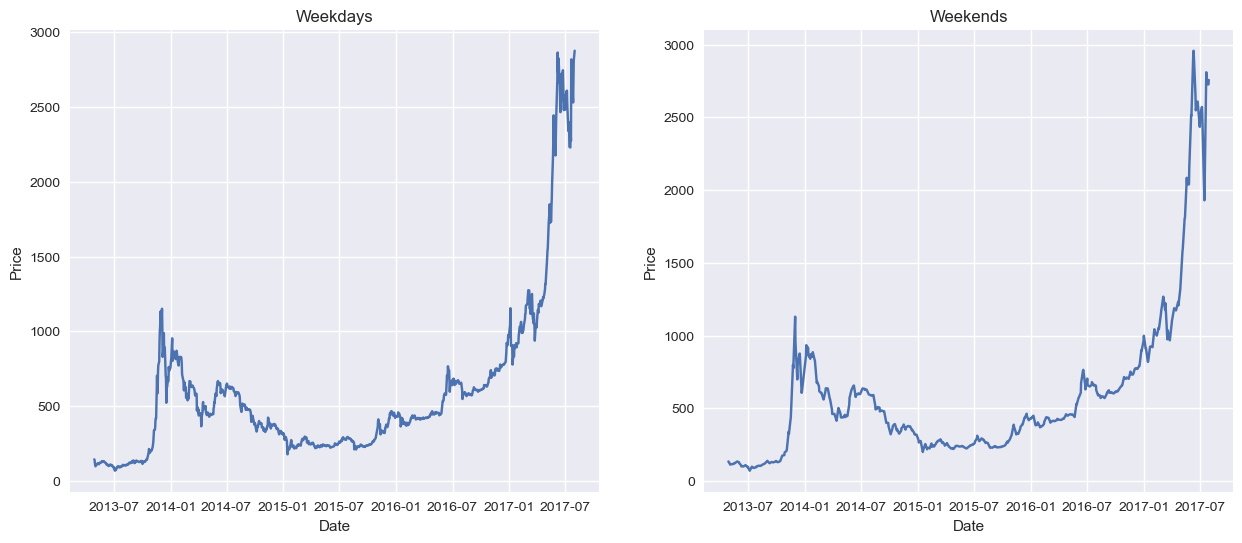

In [157]:
# separate weekdays and weekends
df['Weekend'] = (df.index.weekday > 4).astype(bool)

fig, _ = plot_2_cols_series(
    df[df['Weekend'] == False]['price'],df[df['Weekend'] == True]['price'], 
    title1='Weekdays', 
    xlabel1='Date', 
    ylabel1='Price', 
    title2='Weekends', 
    xlabel2='Date', 
    ylabel2='Price', 
    figsize=(15, 6)
)
save_fig('06_weekdays_vs_weekends', fig)


MSE_1=1387.1668458172462
RMSE_1=37.244688826962246
MSE_2=1378.2510950450458
RMSE_2=37.124804309855236


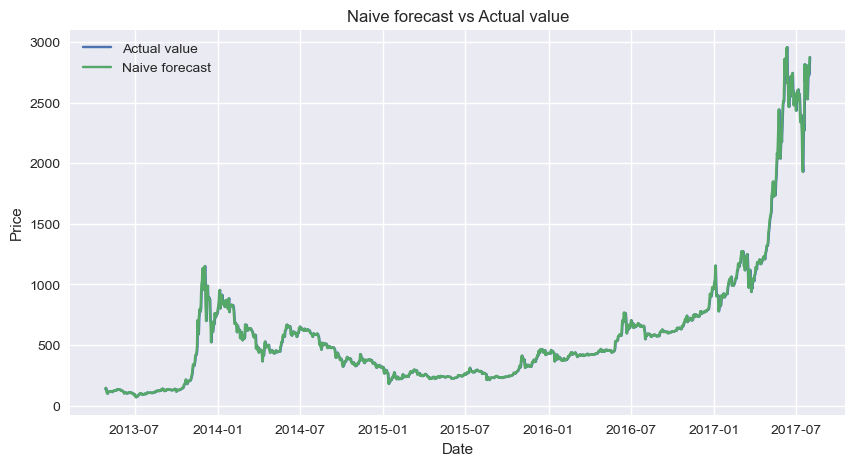

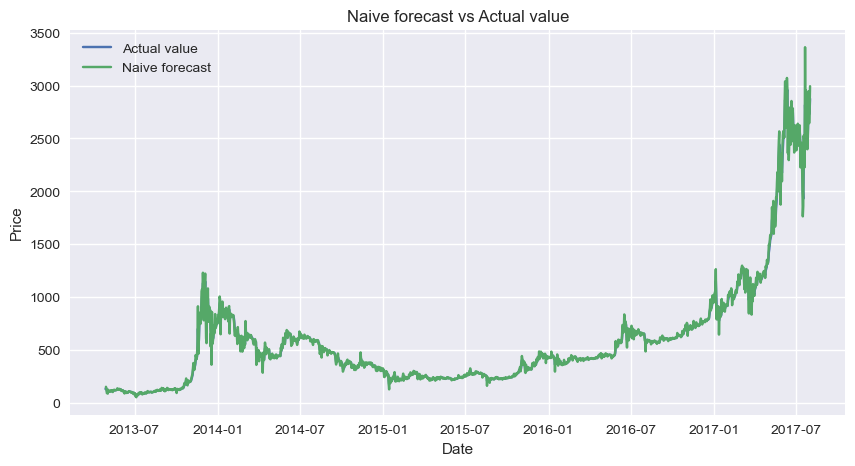

In [158]:
# naive forecast 1
# Y(t+1) = Y(t)
df['naive_forecast_1'] = df['price'].shift(1)
fig, _ = plot_series(df[['price', 'naive_forecast_1']], title='Naive forecast vs Actual value', xlabel='Date', ylabel='Price', labels=['Actual value', 'Naive forecast'])
save_fig('07_naive_forecast_1', fig)

# naive forecast 2
# y(t+1) = y(t) + (y(t) - y(t-1))
df['naive_forecast_2'] = df['price'] + (df['price'] - df['price'].shift(-1))
fig, _ = plot_series(df[['price', 'naive_forecast_2']], title='Naive forecast vs Actual value', xlabel='Date', ylabel='Price', labels=['Actual value', 'Naive forecast'])
save_fig('07_naive_forecast_2', fig)

# compute mean squared error of naive forecast 1
df.dropna(inplace=True)
MSE_1 = mean_squared_error(df['price'], df['naive_forecast_1'])
RMSE_1 = np.sqrt(mean_squared_error(df['price'], df['naive_forecast_1']))

# compute mean squared error of naive forecast 2
df.dropna(inplace=True)
MSE_2 = mean_squared_error(df['price'], df['naive_forecast_2'])
RMSE_2 = np.sqrt(mean_squared_error(df['price'], df['naive_forecast_2']))

print(f"{MSE_1=}")
print(f"{RMSE_1=}")

print(f"{MSE_2=}")
print(f"{RMSE_2=}")

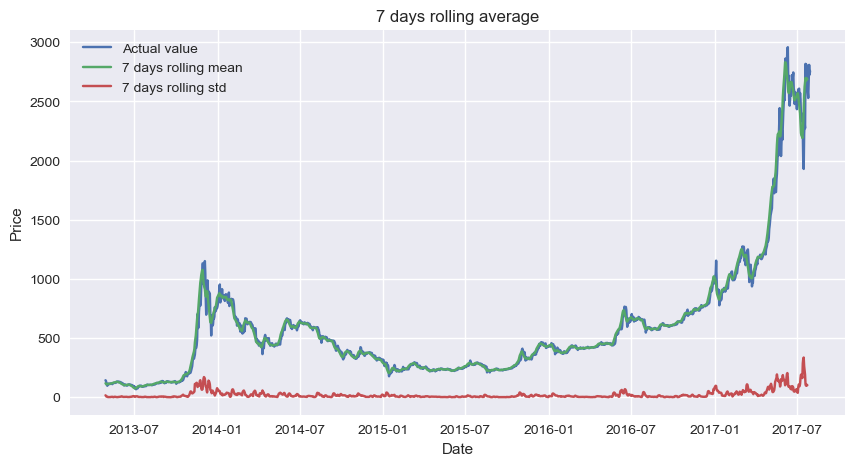

In [159]:
# moving average of 7 days
df['7_day_mean'] = df['price'].rolling(7).mean()
df['7_day_std'] = df['price'].rolling(7).std()

fig, _ = plot_series(df[['price', '7_day_mean', '7_day_std']], title='7 days rolling average', xlabel='Date', ylabel='Price', labels=['Actual value', '7 days rolling mean', '7 days rolling std'])
save_fig('08_7_days_rolling_average_and_std', fig)

In [160]:
# apply adfuller test to check if the series is stationary
result = adfuller(df['price'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}, {value}")

ADF Statistic: -4.873542796244943
p-value: 3.9254452810010056e-05
Critical Values:
	1%, -3.434634049963598
	5%, -2.863432142744973
	10%, -2.5677773493449725


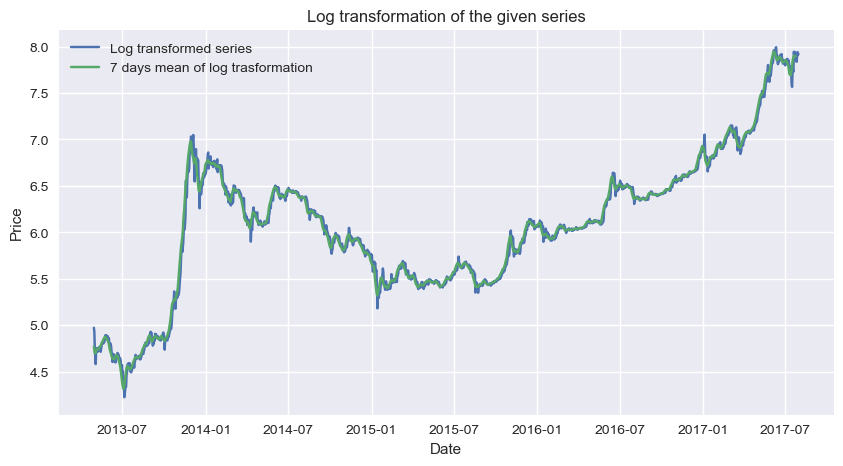

In [161]:
# apply log transformation to the series to remove outliers
df['log'] = np.log(df['price'])
df['log_rolling_mean'] = df['log'].rolling(7).mean()
fig, _ = plot_series(df[['log', 'log_rolling_mean']], title='Log transformation of the given series', xlabel='Date', ylabel='Price', labels=['Log transformed series', '7 days mean of log trasformation'])
save_fig('09_log_transformation', fig)

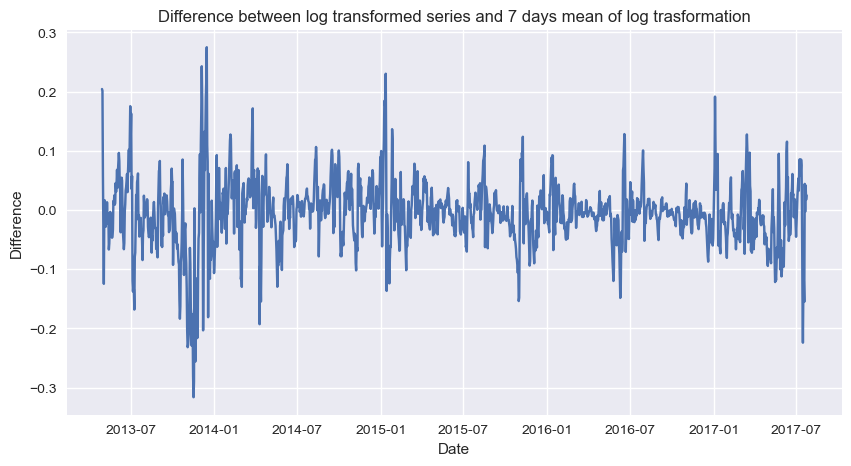

In [162]:
df['log_diff'] = df['log'] - df['log_rolling_mean']
fig, _ = plot_series(df['log_diff'], title='Difference between log transformed series and 7 days mean of log trasformation', xlabel='Date', ylabel='Difference')
save_fig('10_log_diff', fig)

In [163]:
# apply adfuller test to check if the series is stationary
result = adfuller(df['log_diff'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}, {value}")

ADF Statistic: -7.167073326875076
p-value: 2.8679029141003094e-10
Critical Values:
	1%, -3.4346453058155175
	5%, -2.8634371105641443
	10%, -2.5677799947325988


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -102.204
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3638.76    0.00864496       360.029           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3725.52     0.0152283       352.114           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3768.97     0.0037686       161.113           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3789.56     0.0102221       208.528      0.2788           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          3812     0.0148964       339.211           1           1      600   
    Iter      log prob        ||dx||      ||grad||       alpha  

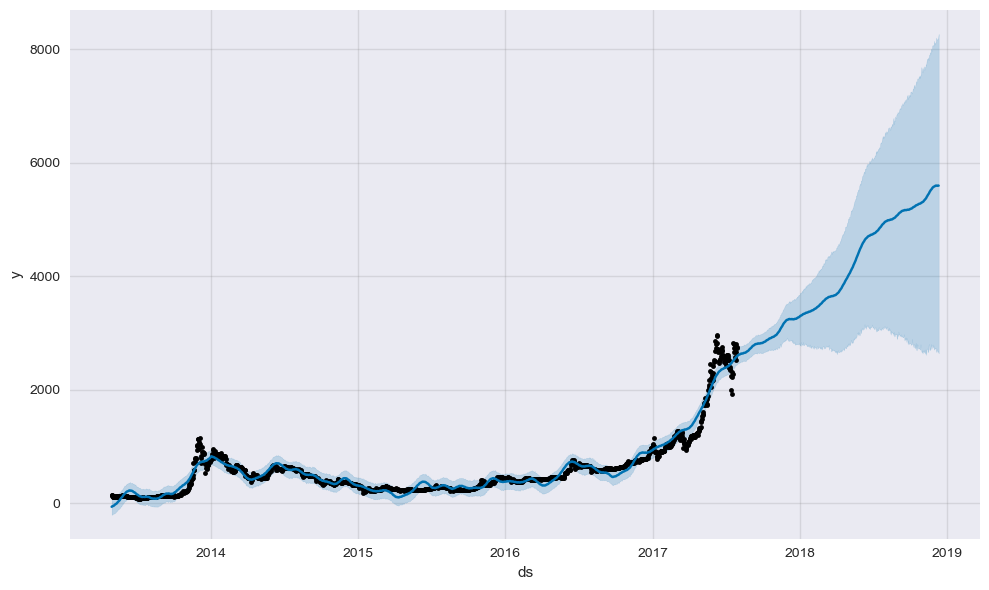

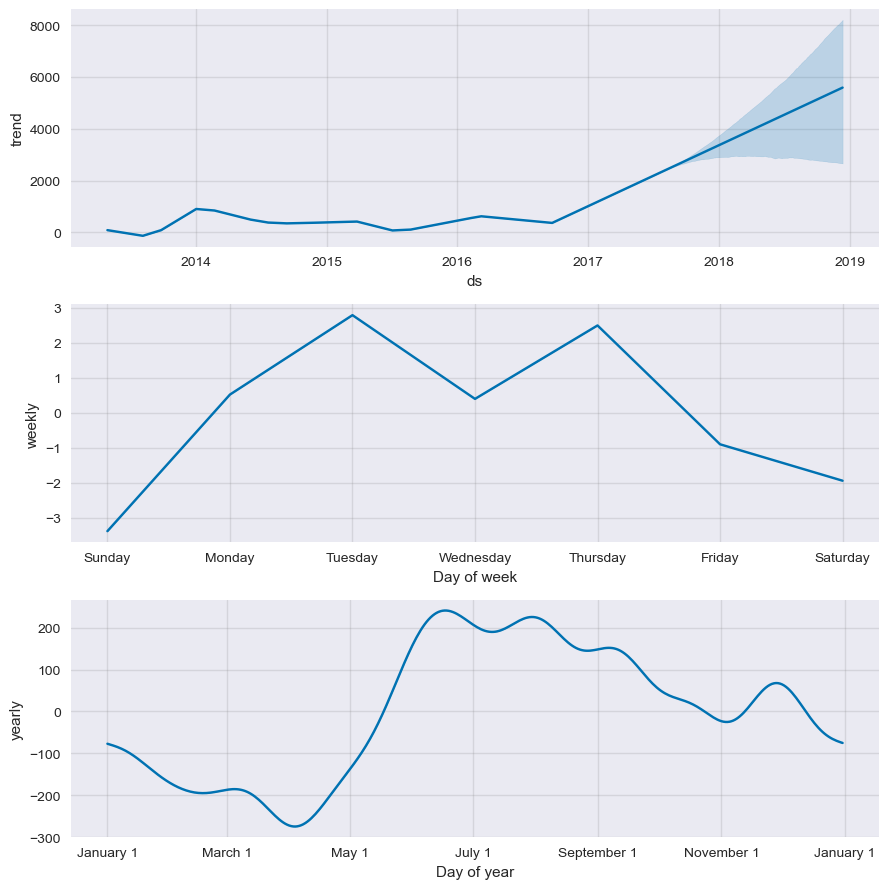

In [164]:
# prepare data for prophet
df['ds'] = df.index
df['y'] = df['price']

# forecast using prophet
model = Prophet()

model.fit(df)
df_forecast = model.predict(model.make_future_dataframe(periods=500, freq='D'))

# plot forecast
fig = model.plot(df_forecast)
fig2 = model.plot_components(df_forecast)

save_fig('11_prophet_forecast', fig)
save_fig('12_prophet_forecast_components', fig2)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-07-30 00:00:00 and 2016-07-30 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -26.8655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2369.9     0.0418086       281.033           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2439.98    0.00348191       182.681           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2450.12   0.000751594       204.602   7.664e-06       0.001      318  LS failed, Hessian reset 
     299       2463.51      0.115161       501.122      0.9258      0.9258      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2496.35     0.0243559       195.809           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     477       2504.66   0.000916141    

/opt/anaconda3/lib/python3.9/site-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.9/site-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


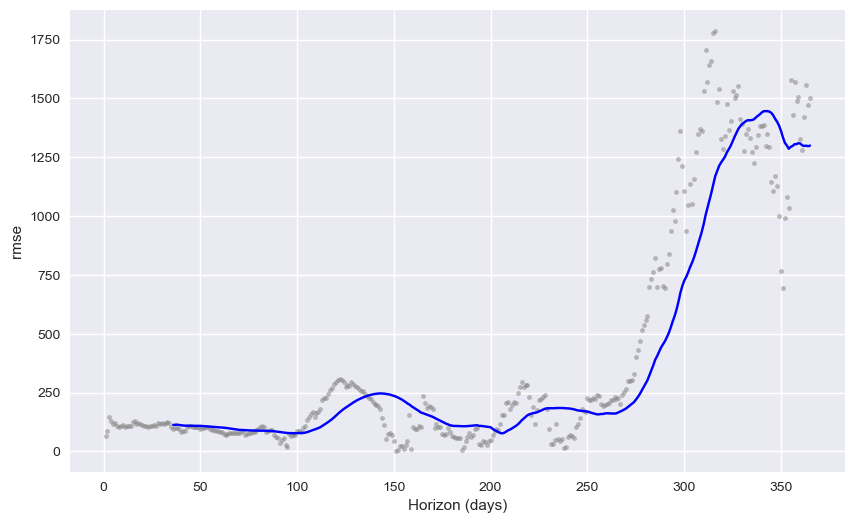

In [165]:
# perform cross validation
df_cv = cross_validation(model, horizon='365 days')
fig = plot_cross_validation_metric(df_cv, metric='rmse')
save_fig('13_prophet_cross_validation', fig)

In [166]:
# compute root mean squared error on test dataset
df_test = pd.read_csv('dataset/bitcoin_price_test.csv', index_col='Date', parse_dates=True)

df_test['ds'] = df_test.index
df_test['y'] = df_test['Close']

df_forecast = model.predict(model.make_future_dataframe(periods=len(df_test) + 1, freq='D'))
df_forecast.index = df_forecast['ds']

y_hat = df_forecast['yhat'].tail(len(df_test))
y_true = df_test['y'][::-1]

MSE = mean_squared_error(y_true, y_hat, squared=True)
RMSE = mean_squared_error(y_true, y_hat, squared=False)

print(f"{MSE=}")
print(f"{RMSE=}")

MSE=206608.83001608335
RMSE=454.54244028042456
